In [12]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model


In [13]:
df = pd.read_csv('../df.csv') #712404
df_test = pd.read_csv('../review_rating_hellody.csv', encoding= 'cp949') #26586
df_train = df[~df['review'].isin(df_test['review'])]

In [14]:
# 데이터프레임을 랜덤하게 섞음
df_shuffled = df_train.sample(frac=1, random_state=42)  

df_shuffled['rating'] = df_shuffled['rating'].astype(float)
df_shuffled['label'] = df_shuffled['rating'].apply(lambda x: 1 if x > 5 else 0)

# 긍정 리뷰와 부정 리뷰 분리
positive_reviews = df_shuffled[df_shuffled['label'] == 1]
negative_reviews = df_shuffled[df_shuffled['label'] == 0]
print(len(positive_reviews)) #530685
print(len(negative_reviews)) #146843

# 클래스 균형을 맞추기 위해 샘플 수 결정
num_samples = min(len(positive_reviews), len(negative_reviews))
print(num_samples) #146843

# 데이터를 샘플링하여 균형 잡힌 데이터셋 생성
positive_samples = positive_reviews.sample(num_samples, random_state=42)
negative_samples = negative_reviews.sample(num_samples, random_state=42)

balanced_df = pd.concat([positive_samples, negative_samples])
balanced_df = balanced_df.sample(frac=1, random_state = 42)
balanced_df.reset_index(inplace= True, drop= True)

530685
146843
146843


In [15]:
data = balanced_df[['review', 'rating', 'label']]
data

,review,rating,label
0,채널 돌리다 발견한 순간 빠져버린 영화,10.0,1
1,오유에서왓쪄용,1.0,0
2,왠지 실화같어 ㅋㅋㅋ 이상하게 재밌네 ㅋ,10.0,1
3,에휴 ... 만 나오네요,1.0,0
4,기대를 너무 많이 했나.. 그래도 어느 정도 볼만하고최연소 아카데미 여우주연상 후보...,7.0,1
...,...,...,...
293681,제천에서 구경남의 후배감독은 소설가 김연수씨였다...,10.0,1
293682,이게뭐야 장난하냐? 아욕나오네,1.0,0
293683,"씨네프에서해주길래 밨다, 사랑내용이 의외로 뭉클하게 볼만하드라, 근데,, 중...",8.0,1
293684,작가적 마인드로 C급 철학을 발산하는 것과 만듦 자체가 3류 밖에 안되는 거랑 혼동...,1.0,0


In [16]:
data_emotion = data[:150000]
data_emotion.dropna(axis= 0, how= 'any', inplace= True)

C:\Users\USER\AppData\Local\Temp\ipykernel_1868\2591883399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emotion.dropna(axis= 0, how= 'any', inplace= True)


In [17]:
def text_cleaning(text) :
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
  result = hangul.sub('', text)
  return result

In [18]:
data_emotion['ko_review'] = data_emotion['review'].apply(lambda x : text_cleaning(x))
del data_emotion['review']
data_emotion['ko_review'] = data_emotion['ko_review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
data_emotion['ko_review'].replace('', np.nan, inplace=True)
print(data_emotion.isnull().sum())

rating         0
label          0
ko_review    535
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_1868\1860517394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emotion['ko_review'] = data_emotion['review'].apply(lambda x : text_cleaning(x))
C:\Users\USER\AppData\Local\Temp\ipykernel_1868\1860517394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emotion['ko_review'] = data_emotion['ko_review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
C:\Users\USER\AppData\Local\Temp\ipykernel_1868\1860517394.py:4: FutureWarning: A value is t

In [19]:
data_emotion = data_emotion.dropna(how = 'any' , axis = 0)
data_emotion.reset_index(drop = True, inplace = True)
data_emotion #149459


,rating,label,ko_review
0,10.0,1,채널 돌리다 발견한 순간 빠져버린 영화
1,1.0,0,오유에서왓쪄용
2,10.0,1,왠지 실화같어 ㅋㅋㅋ 이상하게 재밌네 ㅋ
3,1.0,0,에휴 만 나오네요
4,7.0,1,기대를 너무 많이 했나 그래도 어느 정도 볼만하고최연소 아카데미 여우주연상 후보에 ...
...,...,...,...
149454,9.0,1,로맨틱과 코미디 사이 정작 메리보다 네 남자들의 처절함이 돋보이는 작품 끝이 안보이...
149455,10.0,1,학창시절 아무 영화나 찾다가 보게된 영화 아직도 기억에 남는걸 보면 참 재밋게 본거...
149456,10.0,1,이때 김민종 간지 쩔었음
149457,1.0,0,브래드피트만을 위한 영화 뭘 말하고 싶은건지 모르겠다 평점이 너무 과해 점 줌


In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [21]:
okt = Okt()

def get_token(x) :
  tokenized_sentence = okt.morphs(x, stem = True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  return stopwords_removed_sentence

In [22]:
X = data_emotion[['ko_review']]
X['ko_review'] = X['ko_review'].apply(get_token) #10만개 32m 52.3s / 5만개 16m 52.9s
y = data_emotion[['label']]

C:\Users\USER\AppData\Local\Temp\ipykernel_1868\2003343989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ko_review'] = X['ko_review'].apply(get_token) #10만개 32m 52.3s / 5만개 16m 52.9s


In [23]:
drop_train = [index for index, sentence in enumerate(X['ko_review']) if len(sentence) < 1]
len(drop_train) #435

435

In [24]:
X.drop(index= drop_train, axis= 0, inplace= True)
y.drop(index= drop_train, axis= 0, inplace= True)

print(len(X)) #149024
print(len(y))

149024
149024


C:\Users\USER\AppData\Local\Temp\ipykernel_1868\2559159681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index= drop_train, axis= 0, inplace= True)
C:\Users\USER\AppData\Local\Temp\ipykernel_1868\2559159681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(index= drop_train, axis= 0, inplace= True)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X['ko_review'] , y, test_size= 0.2)

In [26]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) # 단어 사전 생성
print(tokenizer.word_index)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test) # 정수 인코딩
y_train = np.array(y_train['label'])
y_test = np.array(y_test['label'])

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '있다': 5, '이다': 6, '좋다': 7, '너무': 8, '만': 9, '적': 10, '다': 11, '되다': 12, '같다': 13, '않다': 14, '아니다': 15, '로': 16, '정말': 17, '재밌다': 18, '점': 19, '에서': 20, '진짜': 21, '것': 22, '만들다': 23, '나오다': 24, '연기': 25, '그': 26, '인': 27, '스토리': 28, '못': 29, '생각': 30, '평점': 31, '나': 32, '안': 33, '내': 34, '사람': 35, '더': 36, '게': 37, '그냥': 38, '왜': 39, '드라마': 40, '고': 41, '볼': 42, '지루하다': 43, '배우': 44, '최고': 45, '내용': 46, '재미': 47, '보고': 48, '말': 49, '감동': 50, '이렇다': 51, '때': 52, 'ㅋㅋ': 53, '감독': 54, '아깝다': 55, '자다': 56, '재미있다': 57, '뭐': 58, '주다': 59, '거': 60, '아': 61, '요': 62, '까지': 63, '수': 64, '시간': 65, '그렇다': 66, '하고': 67, '재미없다': 68, '모르다': 69, '중': 70, '가다': 71, '들다': 72, '네': 73, '싶다': 74, '작품': 75, '사랑': 76, '액션': 77, '지': 78, '쓰레기': 79, '알다': 80, '마지막': 81, '정도': 82, '하나': 83, '저': 84, '주인공': 85, '괜찮다': 86, '느낌': 87, '장면': 88, '많다': 89, '이야기': 90, '별로': 91, 'ㅋ': 92, '듯': 93, '이건': 94, '다시': 95, 'ㅋㅋㅋ': 96, '나다': 97, '차다': 98, '오다': 99, '안되다': 100, '끝': 101, '연출':

In [27]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size #39516

39578

리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 10.875967756817285


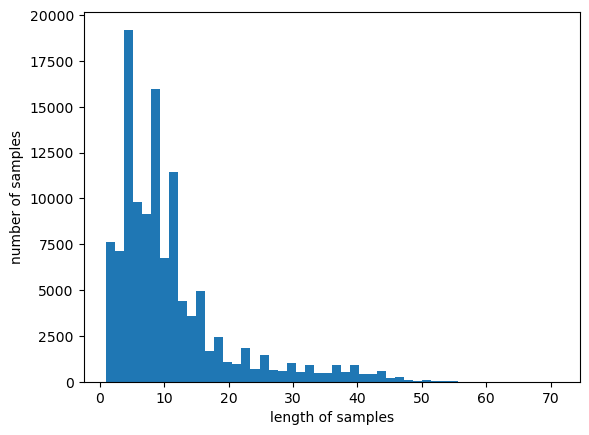

In [28]:
# 패딩
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
review_lengths = [len(review) for review in X_train]
# 95% 이상을 차지하는 리뷰 길이 계산
sorted_lengths = sorted(review_lengths)
percentile_99_length = np.percentile(sorted_lengths, 99)
print('99% 이상을 차지하는 리뷰의 길이:', percentile_99_length)

max_len = int(percentile_99_length)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

99% 이상을 차지하는 리뷰의 길이: 43.0


In [30]:
print(len(X_test))
print(len(y_test)) #29805
print(len(X_train)) #119219

29805
29805
119219


다중 로지스틱 회귀

###### 은닉층 없는 경우

In [31]:
# # 은닉층 없는 경우
# from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'batch_size': [32, 64, 128],
#     'epochs': [20, 30, 40]
# }

# input_dim = X_train.shape[1]
# best_accuracy = 0
# best_params = None

# # 파라미터 그리드 생성
# grid = ParameterGrid(param_grid)

# for params in grid:
#     learning_rate = params['learning_rate']
#     batch_size = params['batch_size']
#     epochs = params['epochs']
    
#     optimizer = SGD(learning_rate=learning_rate)
    
#     # 모델 구성
#     model = Sequential()
#     model.add(Input(shape = (max_len, )))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)    
#     mc = ModelCheckpoint('MLR.keras', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
#     # 모델 학습
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=0)
    
#     val_accuracy = max(history.history['val_binary_accuracy'])
    
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_params = params

# print('Best Accuracy:', best_accuracy)
# print('Best Parameters:', best_params)


In [32]:
# # 은닉층 없는 경우
# from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# optimizer = SGD(learning_rate=0.01)

# # 모델 구성
# model = Sequential()
# model.add(Input(shape = (max_len, )))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)    
# mc = ModelCheckpoint('MLR.keras', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)
# # 모델 학습
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split = 0.2, verbose= 1)

# val_accuracy = max(history.history['val_binary_accuracy'])
# print(val_accuracy)

In [33]:
# print(model.predict(X_test))
# print(model.evaluate(X_test, y_test)[1]) #49.78%

In [34]:
# from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# # 하이퍼파라미터 그리드 설정
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'batch_size': [32, 64, 128],
#     'epochs': [20, 30, 40],
#     'hidden_units': [64, 128, 256],    
# }

# input_dim = X_train.shape[1]
# best_accuracy = 0
# best_params = None

# # 파라미터 그리드 생성
# grid = ParameterGrid(param_grid)

# for params in grid:
#     learning_rate = params['learning_rate']
#     batch_size = params['batch_size']
#     epochs = params['epochs']
#     hidden_units = params['hidden_units']    


#     optimizer = SGD(learning_rate=learning_rate)
    
#     # 모델 구성
#     model = Sequential()
#     model.add(Input(shape = (max_len, )))
#     model.add(Dense(hidden_units, activation='relu'))  # 은닉층 추가
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)    
#     mc = ModelCheckpoint('MLR_hidden1.keras', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)    
#     # 모델 학습
#     history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=0)
    
#     val_accuracy = max(history.history['val_binary_accuracy'])
    
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_params = params

# print('Best Accuracy:', best_accuracy)
# print('Best Parameters:', best_params)


In [35]:
# print(model.predict(X_test))
# print(model.evaluate(X_test, y_test)[1]) #50.33%

CNN

In [36]:
# from sklearn.model_selection import ParameterGrid
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.optimizers import RMSprop

# embedding_dim = 256
# dropout_ratio = 0.3
# hidden_units = 128
# kernel_size = 3
# num_filters = 256
# optimizer = RMSprop(learning_rate= 0.01)

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim))
# model.add(Dropout(dropout_ratio))
# model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))
# model.add(Dense(1, activation='sigmoid'))


# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# mc = ModelCheckpoint('best_model_CNN.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, mc], verbose=1)

# val_accuracy = max(history.history['val_acc'])

# print(val_accuracy)

In [37]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [38]:
# print(model.predict(X_test))
# print(model.evaluate(X_test, y_test)[1]) #75.89

LSTM

In [44]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam, RMSprop

embedding_dim = 100
dropout_ratio = 0.3
hidden_units = 128
optimizer = RMSprop(learning_rate= 0.01)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_LSTM_30.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=30, batch_size= 64, validation_split = 0.2, callbacks=[mc], verbose=1)

val_accuracy = max(history.history['val_acc'])
print(val_accuracy)

Epoch 1/30
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.7286 - loss: 0.5276
Epoch 1: val_acc improved from -inf to 0.79638, saving model to best_model_LSTM_30.keras
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 86s 56ms/step - acc: 0.7286 - loss: 0.5276 - val_acc: 0.7964 - val_loss: 0.4337
Epoch 2/30
1490/1491 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.8338 - loss: 0.3860
Epoch 2: val_acc improved from 0.79638 to 0.80234, saving model to best_model_LSTM_30.keras
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - acc: 0.8338 - loss: 0.3860 - val_acc: 0.8023 - val_loss: 0.4286
Epoch 3/30
1490/1491 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.8690 - loss: 0.3172
Epoch 3: val_acc did not improve from 0.80234
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 78s 53ms/step - acc: 0.8690 - loss: 0.3172 - val_acc: 0.7927 - val_loss: 0.4750
Epoch 4/30
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.8897 - loss: 0.2725
Epoch 4: val_acc did not improve from 0.80234
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 86s 58ms/step - acc: 0.8897

In [43]:
# model.save('best_model_LSTM.keras')

0.8023402094841003


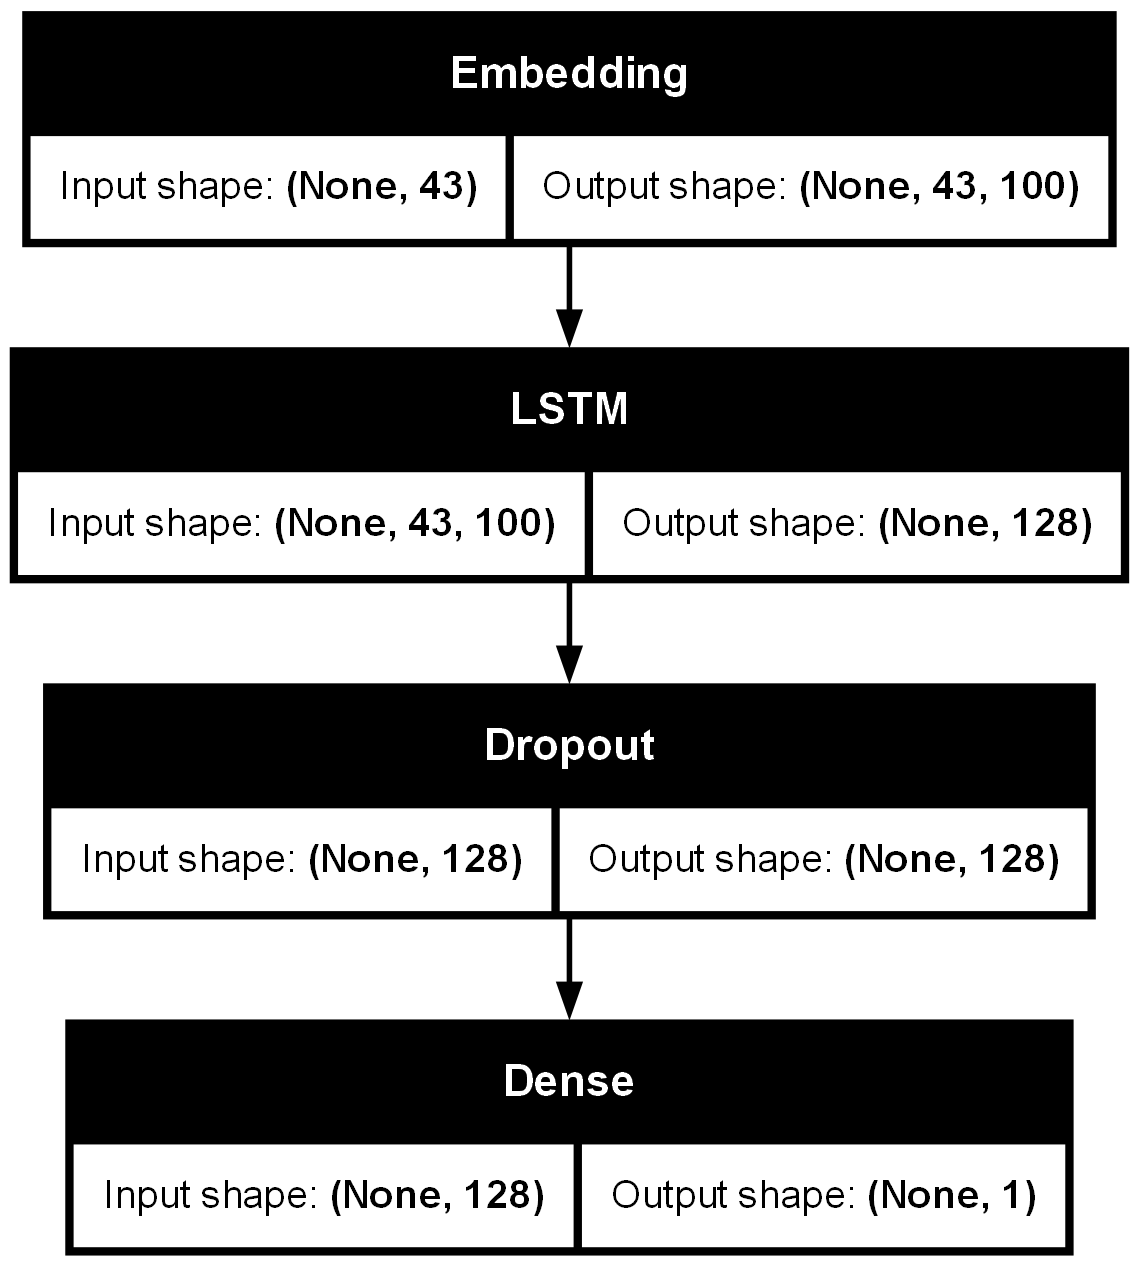

In [45]:
print(val_accuracy) #80.23

plot_model(model, show_shapes=True)


In [46]:
print(model.predict(X_test))
print(model.evaluate(X_test, y_test)[1]) #76.90%

932/932 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step
[[0.04740952]
 [0.99773914]
 [0.00282916]
 ...
 [0.01292788]
 [0.15003549]
 [0.97928774]]
932/932 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - acc: 0.7694 - loss: 0.6212
0.7686965465545654
